In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

# Load Data
ticker = "AAPL"  # Change ticker if needed
data = yf.download(ticker, start="2015-01-01", end="2025-01-01")
data = data[['Close']]  # Using only Close price


[*********************100%***********************]  1 of 1 completed


In [12]:

data = data.copy()

# Moving Averages
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# Exponential Moving Average
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()

# MACD
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']

# Bollinger Bands
data['Upper_BB'] = data['SMA_30'] + (2 * data['Close'].rolling(window=30).std())
data['Lower_BB'] = data['SMA_30'] - (2 * data['Close'].rolling(window=30).std())

# Drop NaN values
data.dropna(inplace=True)

# Select features
features = ['Close', 'SMA_10', 'SMA_30', 'EMA_10', 'MACD', 'Upper_BB', 'Lower_BB']
df = data[features]


In [13]:
data.loc[:, 'SMA_10'] = data['Close'].rolling(window=10).mean()
data.loc[:, 'SMA_30'] = data['Close'].rolling(window=30).mean()

data.loc[:, 'EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data.loc[:, 'EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data.loc[:, 'EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data.loc[:, 'MACD'] = data['EMA_12'] - data['EMA_26']

data.loc[:, 'Upper_BB'] = data['SMA_30'] + (2 * data['Close'].rolling(window=30).std())
data.loc[:, 'Lower_BB'] = data['SMA_30'] - (2 * data['Close'].rolling(window=30).std())

# Drop NaN values
data.dropna(inplace=True)

# Select features
features = ['Close', 'SMA_10', 'SMA_30', 'EMA_10', 'MACD', 'Upper_BB', 'Lower_BB']
df = data[features]

In [14]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [15]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])  # 30 days of past data
        y.append(data[i + time_steps, 0])  # Predict 'Close' price
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

# Train-Test Split
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print(X_train.shape, X_test.shape)  # Should be (samples, 30, features)


(1942, 30, 7) (486, 30, 7)


C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0285 - val_loss: 0.0793 - learning_rate: 0.0010
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0056 - val_loss: 0.0332 - learning_rate: 0.0010
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0031 - val_loss: 0.0594 - learning_rate: 0.0010
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0023 - val_loss: 0.0633 - learning_rate: 0.0010
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0025 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0019 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 8/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0016 - val_loss: 0

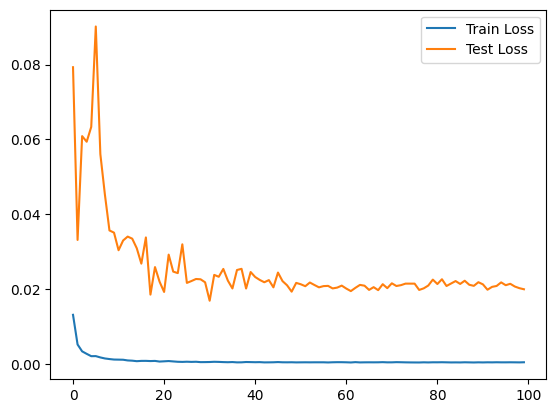

In [8]:
# Define input shape
time_steps = X_train.shape[1]    # Number of time steps
num_features = X_train.shape[2]  # Number of features

# Define CNN-LSTM Model
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', padding="same", input_shape=(time_steps, num_features)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"),
    MaxPooling1D(pool_size=2),

    LSTM(64, return_sequences=True),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler],
    verbose=1
)

# Plot Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()


C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0267 - val_loss: 0.0518 - learning_rate: 0.0010
Epoch 2/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0046 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 3/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0033 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 4/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0026 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 5/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0024 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 6/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0020 - val_loss: 0.0622 - learning_rate: 0.0010
Epoch 7/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0017 - val_loss: 0.0484 - learning_rate: 0.0010
Epoch 8/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0016
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0016 - val_

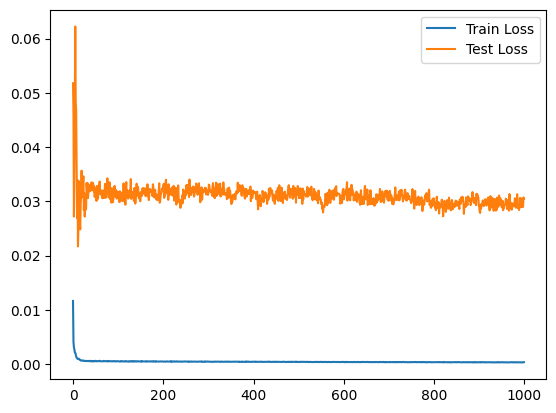

In [11]:
# Define input shape
time_steps = X_train.shape[1]    # Number of time steps
num_features = X_train.shape[2]  # Number of features

# Define CNN-LSTM Model
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', padding="same", input_shape=(time_steps, num_features)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"),
    MaxPooling1D(pool_size=2),

    LSTM(64, return_sequences=True),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler],
    verbose=1
)

# Plot Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()


In [ ]:
# Define input shape
time_steps = X_train.shape[1]    # Number of time steps
num_features = X_train.shape[2]  # Number of features

# Define CNN-LSTM Model
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', padding="same", input_shape=(time_steps, num_features)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"),
    MaxPooling1D(pool_size=2),

    LSTM(64, return_sequences=True),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=2000,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler],
    verbose=1
)

# Plot Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()



C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2000
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.0249 - val_loss: 0.0210 - learning_rate: 0.0010
Epoch 2/2000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0048 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 3/2000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0032 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 4/2000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0030 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 5/2000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0020 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 6/2000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0017 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 7/2000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0013 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 8/2000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0013 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 9/2000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0011 - val_loss: 0.0070 - lear

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


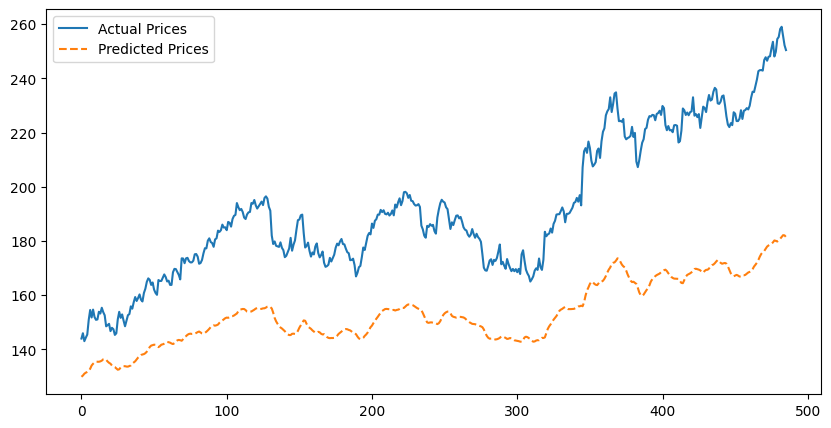

In [12]:
predicted_prices = model.predict(X_test)

# Rescale predictions back to original range
predicted_prices = scaler.inverse_transform(np.hstack((predicted_prices, np.zeros((predicted_prices.shape[0], len(features)-1)))))[:, 0]

# Rescale actual values
actual_prices = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1)))))[:, 0]

# Plot Predictions vs Actual
plt.figure(figsize=(10,5))
plt.plot(actual_prices, label="Actual Prices")
plt.plot(predicted_prices, label="Predicted Prices", linestyle="dashed")
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate MSE & RMSE
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Mean Squared Error (MSE): 1701.4923
Root Mean Squared Error (RMSE): 41.2491
Mean Absolute Error (MAE): 38.4907
